<font color="blue"> Привет. Давай смотреть как ты освоил бустинг

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
import warnings; warnings.simplefilter('ignore')
from time import time
from pathlib import Path
path = Path.cwd()

In [ ]:
autos = pd.read_csv('/datasets/autos.csv'.format(path))
print(autos.info())
print(autos.describe())

В данных есть пропуски, больше всего в поле NotRepaired

In [84]:
autos['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

В основном машины не восстанавливались. Но для 70К записей нет данных<br>
Посмотрим на расспределение по Price, Kilometer, RegistrationYear, NumberOfPictures, PostalCode

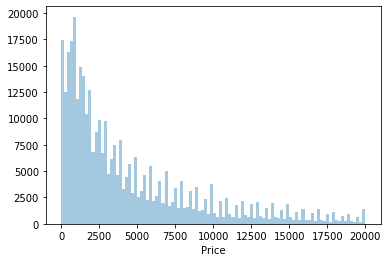

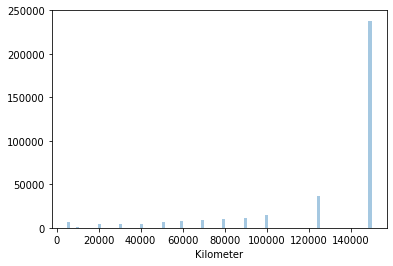

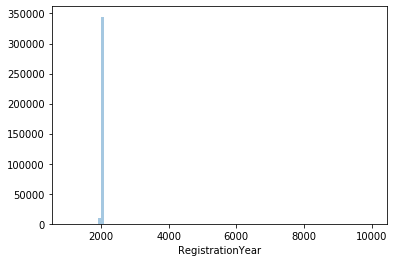

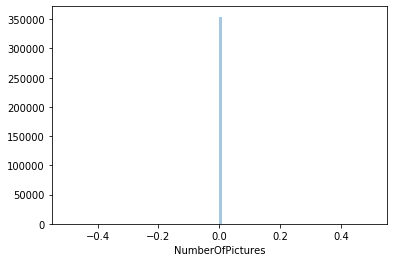

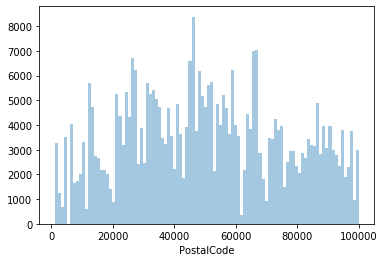

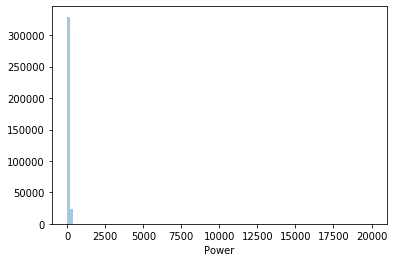

In [85]:
columns = ['Price', 'Kilometer', 'RegistrationYear', 'NumberOfPictures', 'PostalCode', 'Power']
for column in columns:
    plt.figure()
    sns.distplot(autos[column], kde=False, bins=100)

In [86]:
autos[autos['RegistrationYear'] > 2020]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
12946,2016-03-29 18:39:40,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,2016-03-29 00:00:00,0,74523,2016-04-06 04:16:14
15147,2016-03-14 00:52:02,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-13 00:00:00,0,32689,2016-03-21 23:46:46
15870,2016-04-02 11:55:48,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-04-02 00:00:00,0,33649,2016-04-06 09:46:13
17271,2016-03-23 16:43:29,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN,2016-03-23 00:00:00,0,21769,2016-04-05 20:16:15
17346,2016-03-06 16:06:20,6500,NaN,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-06 00:00:00,0,55262,2016-03-30 20:46:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334967,2016-03-20 17:53:51,12000,NaN,4000,NaN,500,golf,5000,0,NaN,volkswagen,no,2016-03-20 00:00:00,0,57392,2016-04-07 00:46:30
335727,2016-03-09 07:01:27,0,NaN,7500,manual,0,other,10000,0,petrol,mini,no,2016-03-09 00:00:00,0,9669,2016-03-19 19:44:50
338829,2016-03-24 19:49:36,50,NaN,3000,NaN,3000,golf,100000,6,NaN,volkswagen,yes,2016-03-24 00:00:00,0,23992,2016-04-03 13:17:57
340548,2016-04-02 17:44:03,0,NaN,3500,manual,75,NaN,5000,3,petrol,sonstige_autos,NaN,2016-04-02 00:00:00,0,96465,2016-04-04 15:17:51


In [87]:
autos['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

In [88]:
autos['Power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
16311        1
1360         1
1968         1
6226         1
6006         1
Name: Power, Length: 712, dtype: int64

После беглого осмотра видим что в данных есть пропуски и ошибки. Кол-во изображений всегда равно 0, этот параметр нам точно не поможет. В датах есть данные из будущего<br>
Пока удалять/заменять ничего не будем, попробуем построить модель с такими данными

<font color="blue">Хорошо

# 2. Обучение моделей

In [89]:
# Подготовка данных с OHE
def preparing_ohe(limit):
    df = pd.read_csv('/datasets/autos.csv').head(limit)
    df = df.drop(columns=['DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen'])

    df_ohe = pd.get_dummies(df, drop_first=True, columns=['VehicleType', 'NotRepaired', 'RegistrationYear', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType','Brand'])
    X = df_ohe.drop(columns='Price')
    y = df_ohe['Price']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=12345)
    return df_ohe, x_train, x_val, x_test, y_train, y_val, y_test

# Подготовка данных с OrdinalEncoder
def preparing_oe(categorical, limit):
    if limit>=0:
        df = pd.read_csv('/datasets/autos.csv').head(limit)
    elif limit==-1:
        df = pd.read_csv('/datasets/autos.csv')
        
    df = df.drop(columns=['DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen', 'RegistrationMonth'])
    encoder = OrdinalEncoder()
    df[categorical] = df[categorical].fillna('Unknown')
    df[categorical] = encoder.fit_transform(df[categorical])
    X = df.drop(columns='Price')
    y = df['Price']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=12345)
    return df, x_train, x_val, x_test, y_train, y_val, y_test


# Обучение LightGBM модели
def lgb_model_train(features_train, target_train, params, categorical):
    d_train = lgb.Dataset(features_train, label=target_train)
    #params['learning_rate'] = 0.003
    #params['boosting_type'] = 'gbdt'
    #params['objective'] = 'binary'
    #params['metric'] = 'binary_logloss'
    #params['sub_feature'] = 0.5
    #params['num_leaves'] = 10
    #params['min_data'] = 50
    #params['max_depth'] = 3
    clf = lgb.train(params, d_train, 100, categorical_feature=categorical)
    return clf

# Масштабирование признаков
def features_standardscaler(features_train, features_test, numeric):
    sc = StandardScaler()
    sc.fit(features_train[numeric])
    features_train.loc[:, numeric] = sc.transform(features_train[numeric])
    features_test.loc[:, numeric] = sc.transform(features_test[numeric])
    return features_train, features_test


<font color="blue">Отлично что сделал 2 варианта кодирования. Но есть замечание котрое надо добавить к разбиению validation и корректно его применить

Построим LightGBM модель и посчитаем RMSE без подбора гиперпараметров. Kernel падает если брать все данные из датасета, поэтому ограничим выборку 5000 строками

In [90]:
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_ohe(5000)
params = {}
lgb_model = lgb_model_train(features_train, target_train, params, 'auto')
predictions = lgb_model.predict(features_valid)

rmse = mean_squared_error(target_valid, predictions)**0.5
print('RMSE для LightGBM без подбора параметров и масштабирования: {:.2f}'.format(rmse))


RMSE для LightGBM без подбора параметров и масштабирования: 2298.44


Добавим масштабирование признаков

In [91]:
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_ohe(5000)
features_train, features_valid = features_standardscaler(features_train, features_valid, ['Power', 'Kilometer', 'PostalCode'])
params = {}
lgb_model = lgb_model_train(features_train, target_train, params, 'auto')
predictions = lgb_model.predict(features_valid)

rmse = mean_squared_error(target_valid, predictions)**0.5
print('RMSE для LightGBM без подбора параметров с масштабированием: {:.2f}'.format(rmse))

RMSE для LightGBM без подбора параметров с масштабированием: 2277.42


##### Масштабирование особо ничего не дает :( Да и с неполным датасетом работать неудобно, попробуем использовать OrdinalEncoding вместо OHE. Тк OrdinalEncoding не умеет работать с пропусками заполним их значением Unknown

In [92]:
categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode']
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_oe(categorical, -1)
params = {}
start_train_model = time()
lgb_model = lgb_model_train(features_train, target_train, params, categorical)
end_train_model = time()
start_predict = time()
predictions = lgb_model.predict(features_valid)
end_predict = time()
rmse = mean_squared_error(target_valid, predictions)**0.5
print('RMSE для LightGBM без подбора параметров c OrdinalEncoder: {:.2f}'.format(rmse))
print('Время обучения модели: {:.2f}'.format(end_train_model - start_train_model))
print('Время предсказания: {:.2f}'.format(end_predict - start_predict))

RMSE для LightGBM без подбора параметров c OrdinalEncoder: 1756.55
Время обучения модели: 16.83
Время предсказания: 1.21


In [93]:
from sklearn.ensemble import RandomForestRegressor

categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode']
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_oe(categorical, -1)

model = RandomForestRegressor()
start_train_model = time()
model.fit(features_train, target_train)
end_train_model = time()
start_predict = time()
predictions = model.predict(features_valid)
end_predict = time()
rmse = mean_squared_error(target_valid, predictions)**0.5
print('RMSE для RandomForest: {:.2f}'.format(rmse))
print('Время обучения модели: {:.2f}'.format(end_train_model - start_train_model))
print('Время предсказания: {:.2f}'.format(end_predict - start_predict))

RMSE для RandomForest: 1801.75
Время обучения модели: 9.81
Время предсказания: 0.28


In [94]:
from sklearn.linear_model import LinearRegression

categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode']
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_oe(categorical, -1)

model = LinearRegression()
start_train_model = time()
model.fit(features_train, target_train)
end_train_model = time()
start_predict = time()
predictions = model.predict(features_valid)
end_predict = time()
rmse = mean_squared_error(target_valid, predictions)**0.5
print('RMSE для LR: {:.2f}'.format(rmse))
print('Время обучения модели: {:.2f}'.format(end_train_model - start_train_model))
print('Время предсказания: {:.2f}'.format(end_predict - start_predict))

RMSE для LR: 4075.62
Время обучения модели: 0.07
Время предсказания: 0.00


Самой точной оказалась LightGBM, RMSE = 1758, самой быстро LR

# 3. Анализ моделей

Посмотрим как меняется точность, время обучения и время предсказания в зависимости от выбора гиперпараметров

Судя по документации LightGBM основные параметры для тюнинга - num_leaves и min_data_in_leaf, в отличии от RF, где основные параметры n_estimatators и max_depth

In [ ]:
categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode']
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_oe(categorical, -1)
params = {}

for num_leaves in [20, 40, 80]:
    for min_data_in_leaf in [500, 800, 1000, 1500]:
        params['num_leaves'] = num_leaves
        params['min_data_in_leaf'] = min_data_in_leaf
        start_train_model = time()
        lgb_model = lgb_model_train(features_train, target_train, params, categorical)
        end_train_model = time()
        start_predict = time()
        predictions = lgb_model.predict(features_valid)
        end_predict = time()
        rmse = mean_squared_error(target_valid, predictions)**0.5
        print('LightGBM с num_leaves = {}, min_data_in_leaf = {}: RMSE = {:.2f}, Время обучения = {:.2f}, Время предсказания = {:.2f}'.format(num_leaves, min_data_in_leaf, rmse, end_train_model - start_train_model, end_predict - start_predict))
        

LightGBM с num_leaves = 20, min_data_in_leaf = 500: RMSE = 1786.27, Время обучения = 16.53, Время предсказания = 0.92
LightGBM с num_leaves = 20, min_data_in_leaf = 800: RMSE = 1778.96, Время обучения = 8.79, Время предсказания = 0.80
LightGBM с num_leaves = 20, min_data_in_leaf = 1000: RMSE = 1781.68, Время обучения = 7.99, Время предсказания = 0.80
LightGBM с num_leaves = 20, min_data_in_leaf = 1500: RMSE = 1806.36, Время обучения = 7.20, Время предсказания = 0.80
LightGBM с num_leaves = 40, min_data_in_leaf = 500: RMSE = 1742.41, Время обучения = 16.80, Время предсказания = 1.50
LightGBM с num_leaves = 40, min_data_in_leaf = 800: RMSE = 1746.03, Время обучения = 17.30, Время предсказания = 1.20
LightGBM с num_leaves = 40, min_data_in_leaf = 1000: RMSE = 1748.07, Время обучения = 24.69, Время предсказания = 1.30


C увеличением количества листьев времена обучения и предсказания растут, а при увеличении минимального кол-ва данных в листьях падают. Время предсказания варьируется от 1 до 2.4сек. Время обучения меняется от 9 до 20 сек<br>
С помощью подбора параметров удалось немного уменьшить RMSE=1714

<font color="blue">Скорее не тюнинг, а подбор параметров. Тюнинг всё же более тонкая и более хардкорная операция

In [ ]:
from sklearn.ensemble import RandomForestRegressor

categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode']
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_oe(categorical, -1)

for n_estimators in [10, 50, 90]:
    for max_depth in [1, 3, 7, 20]:
        model = RandomForestRegressor(n_estimators = n_estimators, max_depth=max_depth)
        start_train_model = time()
        model.fit(features_train, target_train)
        end_train_model = time()
        start_predict = time()
        predictions = model.predict(features_valid)
        end_predict = time()
        rmse = mean_squared_error(target_valid, predictions)**0.5
        print('RF n_estimators = {}, max_depth = {}: RMSE = {:.2f}, Время обучения = {:.2f}, Время предсказания = {:.2f}'.format(n_estimators, max_depth, rmse, end_train_model - start_train_model, end_predict - start_predict))



In [ ]:
categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode']
autos, features_train, features_valid, features_test, target_train, target_valid, target_test = preparing_oe(categorical, -1)

model = LinearRegression()
start_train_model = time()
model.fit(features_train, target_train)
end_train_model = time()
start_predict = time()
predictions = model.predict(features_valid)
end_predict = time()
rmse = mean_squared_error(target_valid, predictions)**0.5
print('LR: RMSE = {:.2f}, Время обучения = {:.2f}, Время предсказания = {:.2f}'.format(rmse, end_train_model - start_train_model, end_predict - start_predict))

#### Сравнивали 3 модели: LightGBM, RF и LR
Параметр | LightRGM | RF | LR
--- | --- | --- | ---
RMSE_min | 1714 | 1722 | 4049
Время обучения | среднее | быстро-плохо, медленно-хорошо | быстро
Время предсказания | средне-медленно  | быстро | супербыстро

1. С помощью LightRGM и RF можно добиться одинаковой точности, но с LightRGM обучение будет происходить быстрее. Например, чтобы добиться RMSE=1714 LightRGM обучалась 19сек, а RF для RMSE=1722 потребовалось 82 сек
2. Предсказание RF работает так же как LightRGM (около 3 сек) когда хотим высокой точности. Если точностью можно принебречь, то скорость предсказания RF будет выше
3. LR работает быстрее и хуже всех

<font color="blue">Вывод отличный. Но я бы попросил добавить прям вывод. Вот я заказчик, что же в итоге мне выбрать?

#### Вывод-вывод :)
Надо использовать LightRGM: точность лучше чем у других моделей, время обучения и время предсказания приемлемые. Рекомендуемые гиперпараметры: num_leaves = 80, min_data_in_leaf = 500


In [ ]:
categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode', 'Kilometer']
autos, features_train, features_test, features_valid, target_train, target_test, target_valid = preparing_oe(categorical, -1)
params = {}

num_leaves = 80
min_data_in_leaf = 500
params['num_leaves'] = num_leaves
params['min_data_in_leaf'] = min_data_in_leaf
start_train_model = time()
lgb_model = lgb_model_train(features_train, target_train, params, categorical)
end_train_model = time()
start_predict = time()
predictions = lgb_model.predict(features_test)
end_predict = time()
rmse = mean_squared_error(target_test, predictions)**0.5
print('LightGBM с num_leaves = {}, min_data_in_leaf = {}: RMSE = {:.2f}, Время обучения = {:.2f}, Время предсказания = {:.2f}'.format(num_leaves, min_data_in_leaf, rmse, end_train_model - start_train_model, end_predict - start_predict))


In [ ]:
categorical = ['VehicleType', 'NotRepaired', 'Gearbox', 'Model', 'FuelType', 'Brand', 'PostalCode']
autos, features_train, features_test, features_valid, target_train, target_test, target_valid = preparing_oe(categorical, -1)
params = {}

num_leaves = 80
min_data_in_leaf = 500
params['num_leaves'] = num_leaves
params['min_data_in_leaf'] = min_data_in_leaf
start_train_model = time()
lgb_model = lgb_model_train(features_train, target_train, params, categorical)
end_train_model = time()
start_predict = time()
predictions = lgb_model.predict(features_test)
end_predict = time()
rmse = mean_squared_error(target_test, predictions)**0.5
print('LightGBM с num_leaves = {}, min_data_in_leaf = {}: RMSE = {:.2f}, Время обучения = {:.2f}, Время предсказания = {:.2f}'.format(num_leaves, min_data_in_leaf, rmse, end_train_model - start_train_model, end_predict - start_predict))



На тесте RMSE оказалось таким же как на валидации

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей

<font color="blue">В целом хорошая работа. Чтобы я её зачёл надо добавить разбиение на 3 выборки с соотвествующем сквозным использованием. Еще есть пару моментов, они скорее тебе на посмотреть/подумать. Про данные в начале. Поразмышляй все ли данные так нужны? И обрати внимание на числовые данные. Там никаких странностей не замечаешь?

Добавил разбиение на трейн, валидацию и тест. Не думаю что нужны 'DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen'. Попробовал удалить 'RegistrationMonth' - без него точность на тесте чуть выше! Есть явные ошибки в Power и RegistrationYear - потенциально их можно почистить. Значения поля Kilometer кратны 5000 и ограничены 150К, получается что само поле - категориальное. На тесте добавил Kilometer в список категории, время обучения(-2сек) и предсказания(-0.2сек) немного уменьшились

<font color="blue">Отлично. Зачтено